#Importing required libraries

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

#Data Preprocessing and Feature Engineering

In [35]:
train_data = pd.read_csv('data.csv')

In [36]:
train_data['tail'] = train_data['tail'].apply(lambda x: 1 if x == 'yes' else 0)

In [37]:
le = LabelEncoder()
train_data['species'] = le.fit_transform(train_data['species'])

In [38]:
tfidf = TfidfVectorizer(max_features=500)
X_text = tfidf.fit_transform(train_data['message']).toarray()

In [39]:
train_data['Message_Length'] = train_data['message'].apply(len)
train_data['Word_Count'] = train_data['message'].apply(lambda x: len(x.split()))

In [40]:
X_other = train_data[['fingers', 'tail', 'Message_Length', 'Word_Count']].values
X = np.hstack((X_text, X_other))

In [41]:
y = train_data['species']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Model Testing

In [44]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=150),
    "Random Forest": RandomForestClassifier(max_depth=None,n_estimators=750,min_samples_leaf=1,min_samples_split=3),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=350,learning_rate=0.1,max_depth=8,min_samples_leaf=2,min_samples_split=3),
    "XGBoost": XGBClassifier(n_estimators=450,learning_rate=0.1,max_depth=20,colsample_bytree=0.3),
    "Naive Bayes": GaussianNB(var_smoothing=0.0002848035868435802),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(100,100),activation='logistic',alpha=0.1)
}

results = []
for name, clf in classifiers.items():
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  results.append([name, accuracy])

results_df = pd.DataFrame(results, columns=['Classifier', 'Accuracy'])
print(results_df)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


            Classifier  Accuracy
0  Logistic Regression      0.89
1        Random Forest      0.84
2    Gradient Boosting      0.74
3              XGBoost      0.83
4          Naive Bayes      0.83
5       Neural Network      0.88


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#Creating Ensemble of the models above

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Ensemble Accuracy: 0.88


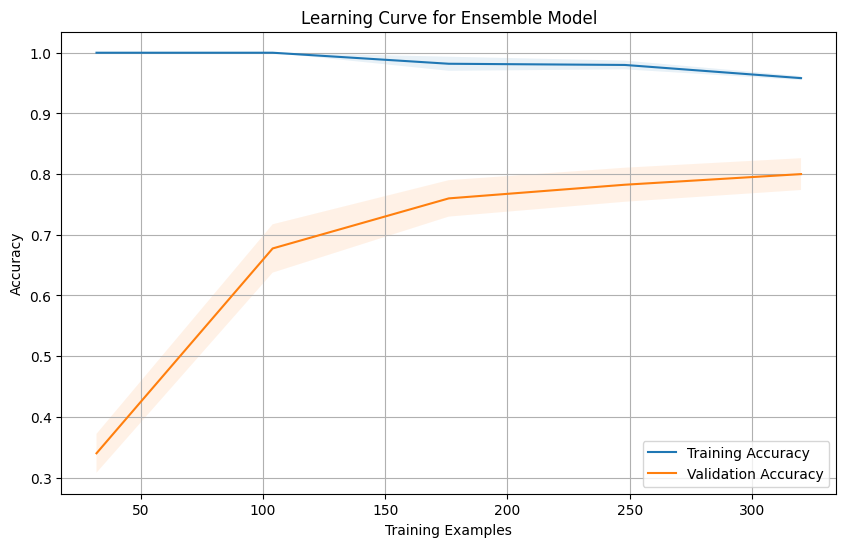

In [46]:

from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

voting_clf = VotingClassifier(estimators=[(name, clf) for name, clf in classifiers.items()], voting='hard')

voting_clf.fit(X_train, y_train)

y_pred = voting_clf.predict(X_test)

ensemble_accuracy = accuracy_score(y_test, y_pred)
print("Ensemble Accuracy:", ensemble_accuracy)

train_sizes, train_scores, test_scores = learning_curve(voting_clf, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
plt.plot(train_sizes, test_mean, label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.title('Learning Curve for Ensemble Model')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [48]:
pred=pd.read_csv('test.csv')
pred.head()

,message,fingers,tail
0,iephyr terram nimbus terram faunar foliar,2,no
1,joyzor uleex luvium caloox shockus blissae,4,yes
2,aquos arbor ventuc,4,yes
3,nympha nympha epikoz nympha mythox mythox mythox,3,no
4,diitax sibenix fabulon,4,yes


#Using Ensemble model created above to predict species of test.csv

In [49]:
pred['tail'] = pred['tail'].apply(lambda x: 1 if x == 'yes' else 0)
X_text = tfidf.transform(pred['message']).toarray()
pred['Message_Length'] = pred['message'].apply(len)
pred['Word_Count'] = pred['message'].apply(lambda x: len(x.split()))
X_other = pred[['fingers', 'tail', 'Message_Length', 'Word_Count']].values
X_pred = np.hstack((X_text, X_other))
predictions = voting_clf.predict(X_pred)
pred['species'] = le.inverse_transform(predictions)

In [50]:
pred['species']

,species
0,Aquari
1,Sentire
2,Florian
3,Faerix
4,Mythron
...,...
294,Faerix
295,Nexoon
296,Mythron
297,Quixnar


In [51]:
predictions_lr = classifiers["Logistic Regression"].predict(X_pred)
pred['species_lr'] = le.inverse_transform(predictions_lr)
comparison_df = pred[['species', 'species_lr']]
print(comparison_df)
accuracy_comparison = accuracy_score(pred['species'], pred['species_lr'])
print(f"Accuracy of Logistic Regression compared to Ensemble: {accuracy_comparison}")


      species species_lr
0      Aquari     Aquari
1     Sentire    Sentire
2     Florian    Florian
3      Faerix     Faerix
4     Mythron    Mythron
..        ...        ...
294    Faerix    Mythron
295    Nexoon     Nexoon
296   Mythron    Mythron
297   Quixnar    Quixnar
298  Emotivor   Emotivor

[299 rows x 2 columns]
Accuracy of Logistic Regression compared to Ensemble: 0.9264214046822743


#Exporting the final output file

In [52]:
pred[['species']].to_csv('result.csv', index=False)